## Environment Setup

In [1]:
! git clone https://github.com/srivarshan-s/CNN-Transfer-Learning.git
% cd CNN-Transfer-Learning/

Cloning into 'CNN-Transfer-Learning'...
remote: Enumerating objects: 25000, done.
remote: Counting objects: 100% (25000/25000), done.
remote: Compressing objects: 100% (24997/24997), done.
remote: Total 25000 (delta 1), reused 24997 (delta 1), pack-reused 0
Receiving objects: 100% (25000/25000), 541.49 MiB | 32.61 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (25001/25001), done.
/content/CNN-Transfer-Learning


## Importing Libraries

In [72]:
import glob
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential, load_model
from keras.applications import vgg16
from keras.models import Model
import keras

import model_evaluation_utils as meu

from tensorflow.keras import optimizers
import tensorflow

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [3]:
np.random.seed(42)

## Load Images

In [4]:
files = glob.glob('train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(12500, 12500)

## Train, Test & Validation Split

In [5]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


## Write Data to Disk

In [6]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

## Prepare Dataset

In [7]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


## Data Preprocessing

(150, 150, 3)


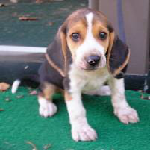

In [8]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [11]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog'] [0 0 0 1 1 0 1 1 0 1]


## Simple CNN Model

In [12]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

In [13]:
history = model.fit(
    x=train_imgs_scaled, y=train_labels_enc, 
    validation_data=(validation_imgs_scaled, validation_labels_enc),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/30
100/100 [==============================] - 37s 66ms/step - loss: 1.1093 - accuracy: 0.5337 - val_loss: 0.7544 - val_accuracy: 0.5000
Epoch 2/30
100/100 [==============================] - 6s 60ms/step - loss: 0.6707 - accuracy: 0.6103 - val_loss: 0.6122 - val_accuracy: 0.6840
Epoch 3/30
100/100 [==============================] - 6s 60ms/step - loss: 0.5804 - accuracy: 0.7020 - val_loss: 0.5437 - val_accuracy: 0.7330
Epoch 4/30
100/100 [==============================] - 6s 61ms/step - loss: 0.4903 - accuracy: 0.7643 - val_loss: 0.5464 - val_accuracy: 0.7310
Epoch 5/30
100/100 [==============================] - 6s 61ms/step - loss: 0.4139 - accuracy: 0.8100 - val_loss: 0.5532 - val_accuracy: 0.7390
Epoch 6/30
100/100 [==============================] - 6s 61ms/step - loss: 0.3222 - accuracy: 0.8603 - val_loss: 0.6722 - val_accuracy: 0.7050
Epoch 7/30
100/100 [==============================] - 6s 61ms/step - loss: 0.2293 - accuracy: 0.9013 - val_loss: 0.7521 - val_accuracy: 0.736

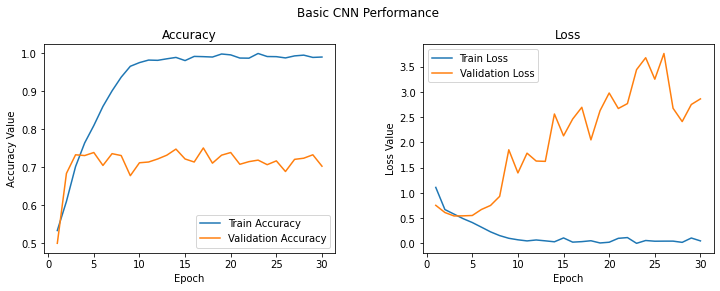

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## CNN Model with Regularization

In [15]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [16]:
history = model.fit(
    x=train_imgs_scaled, y=train_labels_enc,
    validation_data=(validation_imgs_scaled, validation_labels_enc),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/30
100/100 [==============================] - 7s 56ms/step - loss: 0.6931 - accuracy: 0.5460 - val_loss: 1.0734 - val_accuracy: 0.5040
Epoch 2/30
100/100 [==============================] - 5s 52ms/step - loss: 0.6822 - accuracy: 0.5940 - val_loss: 0.6343 - val_accuracy: 0.6160
Epoch 3/30
100/100 [==============================] - 5s 52ms/step - loss: 0.6240 - accuracy: 0.6630 - val_loss: 0.6049 - val_accuracy: 0.6680
Epoch 4/30
100/100 [==============================] - 5s 52ms/step - loss: 0.5826 - accuracy: 0.6970 - val_loss: 0.5415 - val_accuracy: 0.7350
Epoch 5/30
100/100 [==============================] - 5s 51ms/step - loss: 0.5433 - accuracy: 0.7360 - val_loss: 0.5395 - val_accuracy: 0.7330
Epoch 6/30
100/100 [==============================] - 5s 52ms/step - loss: 0.5008 - accuracy: 0.7617 - val_loss: 0.5813 - val_accuracy: 0.7210
Epoch 7/30
100/100 [==============================] - 5s 52ms/step - loss: 0.4471 - accuracy: 0.7933 - val_loss: 0.5907 - val_accuracy: 0.7500

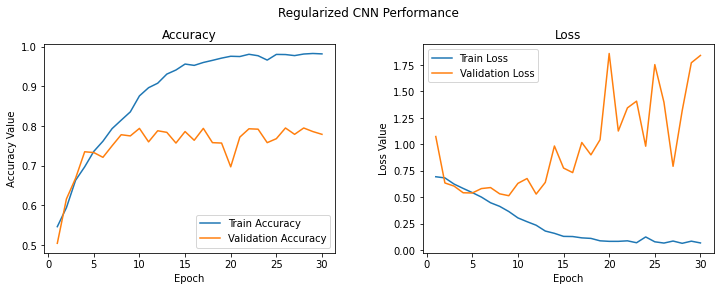

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Regularized CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## CNN Model with Image Augmentation

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255, zoom_range=0.3, rotation_range=50,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
    horizontal_flip=True, fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


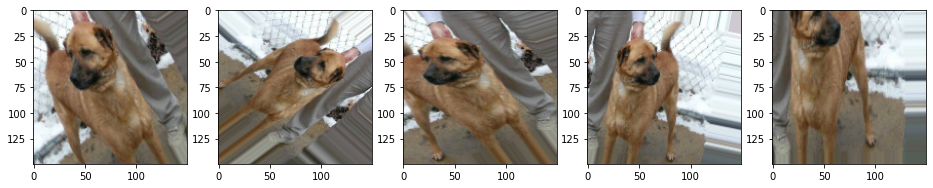

In [21]:
img_id = 2595
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [23]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

In [25]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [26]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)     

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 21s 199ms/step - loss: 0.6897 - accuracy: 0.5290 - val_loss: 0.6803 - val_accuracy: 0.5630
Epoch 2/100
100/100 [==============================] - 19s 195ms/step - loss: 0.6815 - accuracy: 0.5613 - val_loss: 0.6852 - val_accuracy: 0.5290
Epoch 3/100
100/100 [==============================] - 19s 191ms/step - loss: 0.6686 - accuracy: 0.5847 - val_loss: 0.6609 - val_accuracy: 0.5960
Epoch 4/100
100/100 [==============================] - 19s 192ms/step - loss: 0.6608 - accuracy: 0.5967 - val_loss: 0.6691 - val_accuracy: 0.5770
Epoch 5/100
100/100 [==============================] - 19s 190ms/step - loss: 0.6522 - accuracy: 0.6090 - val_loss: 0.6312 - val_accuracy: 0.6400
Epoch 6/100
100/100 [==============================] - 19s 186ms/step - loss: 0.6384 - accuracy: 0.6260 - val_loss: 0.6236 - val_accuracy: 0.6610
Epoch 7/100
100/100 [==============================] - 19s 193ms/step - loss: 0.6320 - accuracy: 0.6347 - val_loss: 0.5981 -

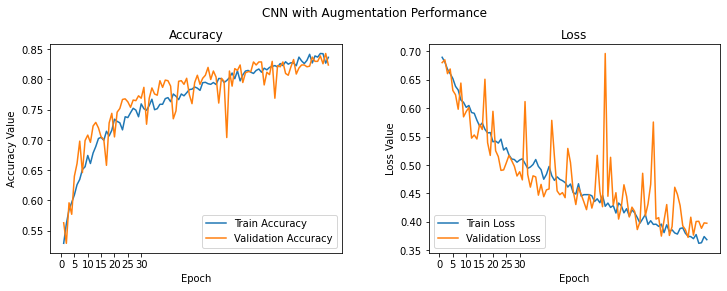

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [30]:
model.save('cats_dogs_cnn_img_aug.h5')

## VGG-16 Model

In [33]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

In [34]:
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

In [35]:
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [36]:
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f59f443fad0>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x7f5a6ab08650>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f5a67e7a110>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f5a6930ab10>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f5a67e7add0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f59f4aafa10>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f59f4aba110>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f59f4ab5210>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f5a6936d310>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f5a6934c4d0>,block3_conv3,False


(1, 4, 4, 512)


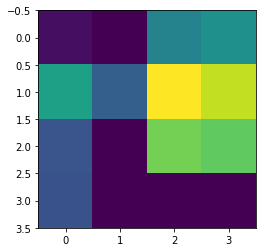

In [37]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [38]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [42]:
input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(
    x=train_features_vgg, y=train_labels_enc,
    validation_data=(validation_features_vgg, validation_labels_enc),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/30
100/100 [==============================] - 2s 11ms/step - loss: 0.4417 - accuracy: 0.7883 - val_loss: 0.3016 - val_accuracy: 0.8730
Epoch 2/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2925 - accuracy: 0.8683 - val_loss: 0.2776 - val_accuracy: 0.8920
Epoch 3/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2453 - accuracy: 0.9000 - val_loss: 0.2787 - val_accuracy: 0.8900
Epoch 4/30
100/100 [==============================] - 1s 8ms/step - loss: 0.2052 - accuracy: 0.9147 - val_loss: 0.2707 - val_accuracy: 0.8960
Epoch 5/30
100/100 [==============================] - 1s 8ms/step - loss: 0.1731 - accuracy: 0.9247 - val_loss: 0.2898 - val_accuracy: 0.8910
Epoch 6/30
100/100 [==============================] - 1s 8ms/step - loss: 0.1460 - accuracy: 0.9387 - val_loss: 0.3046 - val_accuracy: 0.8910
Epoch 7/30
100/100 [==============================] - 1s 8ms/step - loss: 0.1259 - accuracy: 0.9487 - val_loss: 0.2947 - val_accuracy: 0.8990
Epoch

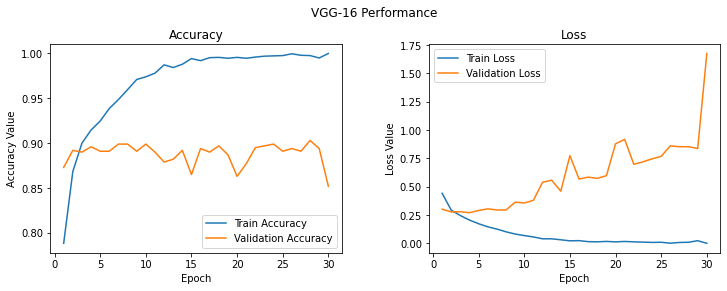

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG-16 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## VGG-16 Model with Data Augmentation

In [45]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [47]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

In [48]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)        

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 36s 306ms/step - loss: 0.6638 - accuracy: 0.5993 - val_loss: 0.5123 - val_accuracy: 0.7900
Epoch 2/100
100/100 [==============================] - 27s 273ms/step - loss: 0.5779 - accuracy: 0.7057 - val_loss: 0.4174 - val_accuracy: 0.8300
Epoch 3/100
100/100 [==============================] - 27s 273ms/step - loss: 0.5235 - accuracy: 0.7457 - val_loss: 0.3788 - val_accuracy: 0.8420
Epoch 4/100
100/100 [==============================] - 28s 275ms/step - loss: 0.4847 - accuracy: 0.7713 - val_loss: 0.3445 - val_accuracy: 0.8510
Epoch 5/100
100/100 [==============================] - 27s 274ms/step - loss: 0.4577 - accuracy: 0.7753 - val_loss: 0.3313 - val_accuracy: 0.8530
Epoch 6/100
100/100 [==============================] - 27s 273ms/step - loss: 0.4558 - accuracy: 0.7800 - val_loss: 0.3336 - val_accuracy: 0.8590
Epoch 7/100
100/100 [==============================] - 28s 279ms/step - loss: 0.4257 - accuracy: 0.8013 - val_loss: 0.3356 -

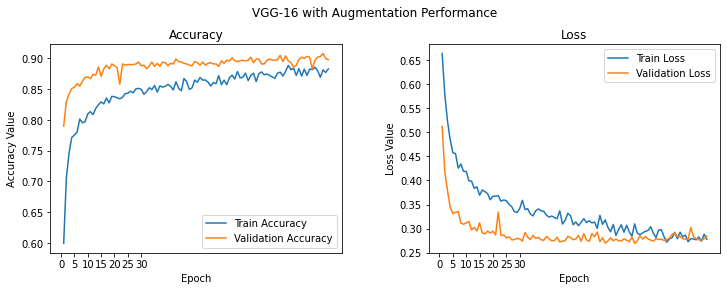

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG-16 with Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [51]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

## VGG-16 with Fine-tuning & Augmentation

In [58]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [59]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])      

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f59f443fad0>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x7f5a6ab08650>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f5a67e7a110>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f5a6930ab10>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f5a67e7add0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f59f4aafa10>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f59f4aba110>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f59f4ab5210>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f5a6936d310>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f5a6934c4d0>,block3_conv3,False


In [60]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [62]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

In [63]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 33s 310ms/step - loss: 0.6266 - accuracy: 0.6363 - val_loss: 0.3569 - val_accuracy: 0.8610
Epoch 2/100
100/100 [==============================] - 31s 307ms/step - loss: 0.4306 - accuracy: 0.7990 - val_loss: 0.2832 - val_accuracy: 0.8950
Epoch 3/100
100/100 [==============================] - 31s 305ms/step - loss: 0.3483 - accuracy: 0.8450 - val_loss: 0.3330 - val_accuracy: 0.8830
Epoch 4/100
100/100 [==============================] - 31s 305ms/step - loss: 0.2979 - accuracy: 0.8760 - val_loss: 0.2749 - val_accuracy: 0.9010
Epoch 5/100
100/100 [==============================] - 30s 304ms/step - loss: 0.2677 - accuracy: 0.8940 - val_loss: 0.1822 - val_accuracy: 0.9420
Epoch 6/100
100/100 [==============================] - 30s 304ms/step - loss: 0.2509 - accuracy: 0.8937 - val_loss: 0.1770 - val_accuracy: 0.9420
Epoch 7/100
100/100 [==============================] - 31s 310ms/step - loss: 0.2193 - accuracy: 0.9100 - val_loss: 0.1603 -

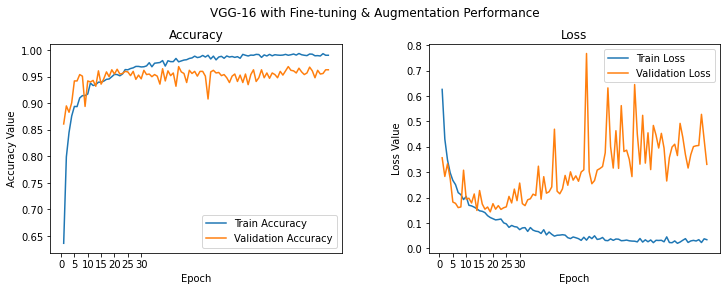

In [64]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG-16 with Fine-tuning & Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [65]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')